In [ ]:
# This script is designed to optimize weekly office hours according to a few
# assumptions (four TAs, two consecutive weekly hours per TA, fixed professor
# office hours, etc.). All of these assumptions are changeable as necessary.

In [ ]:
import itertools, requests, re, scipy.optimize
from bs4 import BeautifulSoup
 
BEN_SLOTS = set(itertools.chain(
                range(36,52),                               #Ben - Sunday
                range(132,192),                             #Ben - Monday
                range(228,242),range(251,288),              #Ben - Tuesday
                range(324,338),range(366,384),              #Ben - Wednesday
                range(420,434),range(462,480),              #Ben - Thursday
                range(516,576),                             #Ben - Friday
                range(612,672)                              #Ben - Saturday
                ))
MICHAEL_SLOTS = set(itertools.chain(
                list(),                                     #Michael - Sunday
                range(144,192),                             #Michael - Monday
                range(240,264),                             #Michael - Tuesday
                range(340,384),                             #Michael - Wednesday
                range(432,456),                             #Michael - Thursday
                range(528,544),                             #Michael - Friday
                list()                                      #Michael - Saturday
                ))
MOYI_SLOTS = set(itertools.chain(
                list(),                                     #Moyi - Sunday
                range(132,144),range(172,184),              #Moyi - Monday
                range(228,240),range(264,280),              #Moyi - Tuesday
                range(324,336),range(360,376),              #Moyi - Wednesday
                range(420,432),range(456,472),              #Moyi - Thursday
                range(516,528),range(552,568),              #Moyi - Friday
                list()                                      #Moyi - Saturday
                ))
TERESSA_SLOTS = set(itertools.chain(
                list(),                                     #Teressa - Sunday
                range(140,160),                             #Teressa - Monday
                list(),                                     #Teressa - Tuesday
                range(332,352),                             #Teressa - Wednesday
                list(),                                     #Teressa - Thursday
                range(524,544),                             #Teressa - Friday
                list()                                      #Teressa - Saturday
                ))
CLASS_TIME_SLOTS = set(itertools.chain(
                range(228,234),                             #Tuesday class
                range(420,426)                              #Thursday class
                ))
CARLY_HOURS = set(range(244,248))        #Carly's hours are Tuesday, 13:00-14:00
 
 
def download_page(pageid):
    '''
    Downloads the results of a when2meet survey.

    Arguments:
        pageid (str): A string corresponding to a valid when2meet URL.
    
    Returns:
        students (dict): A dict whose keys are IDs assigned by when2meet
                         to student responses and whose values
                         are the names associated to the responses.
        slots (dict): A dict whose keys are numbers corresponding to 15-minute
                      weekly times and whose values are lists of students who
                      marked that they are available during those times.
    '''
    resp = requests.get(f'https://www.when2meet.com/?{pageid}')
    soup = BeautifulSoup(resp.content, 'lxml')
    soup_str = str(soup)
    student_id_defs = re.findall('PeopleIDs\[[0-9]+\] = [0-9]+;', soup_str)
    student_name_defs = re.findall('PeopleNames\[[0-9]+\] = .*?;', soup_str)
    students_temp = dict()
    for id_def in student_id_defs:
        temp_num = int(id_def.split('[')[1].split(']')[0])
        student_id = int(id_def.split('=')[1][1:-1])
        students_temp[temp_num] = {'id': student_id}
    for id_def in student_name_defs:
        temp_num = int(id_def.split('[')[1].split(']')[0])
        name = id_def.split('=')[1][2:-2]
        students_temp[temp_num]['name'] = name
    students = {temp['id']: temp['name'] for temp_num, temp in students_temp.items()}
    slot_defs = re.findall('TimeOfSlot\[[0-9]+\]=[0-9]+;', soup_str)
    pushes = re.findall('AvailableAtSlot\[[0-9]+\]\.push\([0-9]+\);', soup_str)
    slots = dict()
    for i in {int(slot_def.split('[')[1].split(']')[0]) for slot_def in slot_defs}:
        slots[i] = set()
    for push in pushes:
        slot = int(push.split('[')[1].split(']')[0])
        student_id = int(push.split('(')[1].split(')')[0])
        slots[slot].add(student_id)
    for student in list(students):
        if not [slot for slot, slot_students in slots.items() if student in slot_students]:
            del students[student]
    return students, slots
 
def interpret_slot(slot):
    '''
    Helper function that takes a slot number per when2meet and converts it
    to a human-readable time.
    '''
    day = slot // 96
    time = slot % 96
    days = [
            'Sunday',
            'Monday',
            'Tuesday',
            'Wednesday',
            'Thursday',
            'Friday',
            'Saturday'
            ]
    hour = time // 4
    minute = 15*(time % 4)
    return f'{days[day]} at {hour}:{str(minute).zfill(2)}'
 
def invert_slots(students, slots):
    '''
    In case respondents to a survey were instructed to mark their
    unavailability instead of availability (such as in the case of the survey
    for which I wrote this script), this function switches availabilities and
    unavailabilities.

    Arguments:
        students (dict), slots (dict): See docstring for download_page.
    
    Returns:
        new_slots (dict): A copy of the slots dict, but where each value is the
                          complement of the corresponding value in slots.
    '''
    new_slots = dict()
    student_ids = set(students.keys())
    for slot in slots.keys():
        new_slots[slot] = student_ids.difference(slots[slot])
    return new_slots
 
def points_eval(x):
    '''
    A numeric helper function for evaluate_hours that determines how much the
    overlap between a particular student's availability and a set of office
    hours is worth. Four 15-minute slots in the (n+1)th hour of a student's
    overlap are weighted as much as one slot in the nth hour.
    '''
    c = x // 4
    e = x % 4
    return 16/3-1/3*4**(2-c)*(4**c-1)-e/4**c
 
def evaluate_hours(hours, students, slots):
    '''
    Given a set of office hours slots and student availabilities, assigns a
    corresponding number of points to each student based on the amount of
    overlap between their availability and the office hours, and then sums the
    "values" associated to these point totals by points_eval.

    Arguments:
        hours (list): A list of lists. Each member list contains the
                            office hours slots of another TA.
        students (dict), slots (dict): See the docstring for download_page.
    
    Returns:
        point_total (float): The sum of points_eval applied to the points
                             assigned to each student corresponding to the
                             overlap between their availability and the office
                             hours.
        points (dict): A dict whose keys are the student IDs of the students in
                       the students dict and whose values are the points
                       assigned to them.
    '''
    points = {student: 0 for student in students}
    for slot, slot_students in slots.items():
        if ([ta for ta in hours if slot in ta] and slot not in CLASS_TIME_SLOTS) \
        or slot in CARLY_HOURS:
            if 426 <= slot < 576:
                # Office hours on Thursday and Friday (i.e. right after
                # assignments are due) are worth much less.
                point_val = 0.5
            elif slot >= 576:
                # Office hours on Saturday are worth a little less.
                point_val = 0.75
            else:
                point_val = 1
            for student in slot_students:
                points[student] += point_val
    return sum(points_eval(x) for student, x in points.items()), points
 
def objective(staff, students, slots):
    '''
    Leverages evaluate_hours into the format required for scipy's
    dual_annealing function to optimize over possible office hours
    configurations.

    Arguments:
        staff (list): A list of slots, corresponding to the first 15-minute
                      slots of each of the TA's weekly hours.
        students (dict), slots (dict): See docstring for download_page.
    
    Returns:
        point_total (float): The number of points returned by evaluate_hours
                             when applied to the hours determined by staff.
    '''
    ben = int(staff[0])
    michael = int(staff[1])
    moyi = int(staff[2])
    teressa = int(staff[3])
    hours = [
             # We assume everyone works two full consecutive hours.
             {i % 672 for i in range(ben,ben+8) if i in BEN_SLOTS},
             {i % 672 for i in range(michael,michael+8) if i in MICHAEL_SLOTS},
             {i % 672 for i in range(moyi,moyi+8) if i in MOYI_SLOTS},
             {i % 672 for i in range(teressa,teressa+8) if i in TERESSA_SLOTS},
            ]
    return evaluate_hours(hours, students, slots)[0]
 
def optimize_hours(students, slots):
    '''
    Uses scipy's dual_annealing function to optimize objective.

    Arguments:
        students (dict), slots (dict): See docstring for download_page.

    Returns:
        results (OptimizeResult): See docstring for
                                  scipy.optimize.dual_annealing.
    '''
    results = scipy.optimize.dual_annealing(objective, [(0,672)]*4,
                                            args=(students, slots),
                                            maxiter=5000,
                                            initial_temp=50000)
    x = results['x']
    result_slots = [interpret_slot(int(i)) for i in x]
    print(f'Value of objective function is {results["fun"]}')
    print(f'Ben works {result_slots[0]}')
    print(f'Michael works {result_slots[1]}')
    print(f'Moyi works {result_slots[2]}')
    print(f'Teressa works {result_slots[3]}')
    return results

In [ ]:
students, slots = download_page('9735283-FkhoO')

In [ ]:
slots = invert_slots(students, slots)

In [ ]:
students_who_filled_out_the_form_in_reverse = [
                                               42402232,
                                               42449648,
                                               42420741,
                                               42607415
                                              ]
for slot in slots.keys():
    for student in students_who_filled_out_the_form_in_reverse:
        if student in slots[slot]:
            slots[slot] = slots[slot].difference({student})
        else:
            slots[slot].add(student)

In [ ]:
results = optimize_hours(students, slots)

Value of objective function is 1.4838612874348769
Ben works Tuesday at 10:30
Michael works Wednesday at 16:00
Moyi works Tuesday at 19:30
Teressa works Monday at 11:30


In [ ]:
staff = results['x']

In [ ]:
ben = int(staff[0])
michael = int(staff[1])
moyi = int(staff[2])
teressa = int(staff[3])
hours = [
               {i for i in range(ben,ben+8) if i in BEN_SLOTS},
               {i for i in range(michael,michael+8) if i in MICHAEL_SLOTS},
               {i for i in range(moyi,moyi+8) if i in MOYI_SLOTS},
               {i for i in range(teressa,teressa+8) if i in TERESSA_SLOTS},
              ]
test, test_points = evaluate_hours(hours, students, slots)

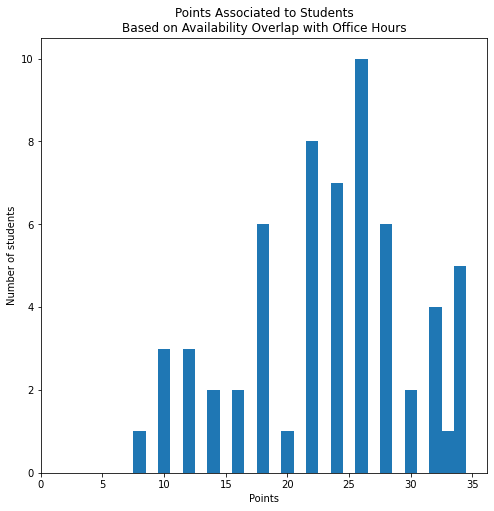

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
axis = plt.gca()
bins = [i-0.5 for i in range(1,max(test_points.values()))]
axis.hist(test_points.values(), bins=bins)
axis.set_title('Points Associated to Students\n'+\
               'Based on Availability Overlap with Office Hours')
axis.set_xlabel('Points')
axis.set_ylabel('Number of students')
xlim = axis.get_xlim()
axis.set_xlim(0, xlim[1]);

In [ ]:
from statistics import mean
[min(test_points.values()), mean(test_points.values())]

[8, 23.953125]

In [ ]:
# Every student can attend the equivalent of at least two full hours.
# The average student can attend almost six full hours.